# Przetwarzanie języka naturalnego w Pythonie

Ten notatnik ma na celu przedstawienie podstawowych kroków, które należy wykonać podczas analizy i klasyfikacji tekstów. W trakcie zadania będziemy tworzyć szereg funkcji pomocniczych, które na koniec wykorzystamy do klasyfikacji krótkich dokumentów tekstowych.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega i jak wykonać tokenizację,
+ potrafić wykonać podstawowy stemming,
+ potrafić analizować najpopularniejsze i narzadsze tokeny w zbiorze dokumentów,
+ zdefiniować i usunąć stopwords,
+ wiedzieć jak zamienić zbiór dokumentów na reprezentację bag-of-words,
+ uruchomić wybrany klasyfikator na przetworzonym zbiorze danych.

## Przygotowanie

Na początek trochę bibliotek i przydatnych wyrażeń regularnych:

In [1]:
import re
import pandas as pd
import nltk

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

Biblioteka [re](https://docs.python.org/2/library/re.html) pozwala definiować wyrażenia regularne, [pandas](http://pandas.pydata.org/) już znasz z ostatnich zajęć, a [nltk](http://www.nltk.org/) to podstawowa biblioteka do przetwarzania języka naturalnego w pythonie. `nltk` to spory zestaw modułów, który domyślnie nie jest instalowany w całości. Aby doinstalować wybrane moduły możesz w interaktywnej konsoli pythona wpisać:

`import nltk
nltk.download()`

Następnie w odpowiednich zakładkach wybrać interesujące moduły. W ramach tego ćwiczenia będziemy wykorzystywać moduł **`punkt`** z zakładki Modules, ale proszę zwrócić uwagę na interesujące korpusy i leksykony, takie jak np. `opinion_lexicon` czy `sentiwordnet`.

Przyda nam się też zbiór danych do testowania kodu.

**Zad. 1: Wczytaj zbiór danych `tweets_train.tsv` do zmiennej `tweets`. Pomiń nagłówek i pozostaw tylko ostatnią kolumnę. Wyświetl pierwsze 6 wierszy, żeby upewnić się, że każdy przykład składa się tylko z tekstu.**

In [2]:
tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None, names=['A','B','data'])
tweets = tweets.iloc[:,2]

In [3]:
tweets[:6]

0    dear @Microsoft the newOoffice for Mac is grea...
1    @Microsoft how about you make a system that do...
2                                        Not Available
3                                        Not Available
4    If I make a game as a #windows10 Universal App...
5    Microsoft, I may not prefer your gaming branch...
Name: data, dtype: object

## Tokenizacja i stemming

Żeby uporządkować trochę kod i kolejne kroki, wprowadźmy klasę Tokenizer i BeforeTokenizationNormalizer. Pierwsza będzie służyć jako klasa bazowa dla tworzonych przez tokenizatorów a druga zamieni encje html na poprawne znaki tekstowe.

In [4]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass
    
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text

Aby sprawdzić czy wszystko działa - odkomentuj poniższy kod:

In [5]:
for i in tweets.index[:3]:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    print(tweet)

dear @microsoft the newooffice for mac is great and all, but no lync update? c'mon.
@microsoft how about you make a system that doesn't eat my friggin discs. this is the 2nd time this has happened and i am so sick of it!
not available


W kolejnych krokach będziesz implementował coraz bardziej wyrafinowane tokenizatory. Zacznijmy od czegoś w miarę intuicyjnego.

**Zad. 2: Napisz tokenizator, który dzieli słowa według spacji. Tokenizator powinien przyjmować tekst (pojedynczego stringa) i zamieniać go na listę słów. Przetestuj kod za pomocą zakomentowanej pętli.**

In [6]:
class SimpleTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Można w tym celu wykorzystać wyrażenie RE_SPACES. Jakie wady ma takie podejście? Jak reaguje na znaki
        # interpunkcyjne? Jeśli usuniesz interpunkcje, co się dzieje ze skrótowcami? Jak obsłużyć słowa can't, o'clock,
        # we'd itp.?
        return re.split(RE_SPACES, text)
        
# Znaki interpunkcyjne występujące zaraz po słowach są uznawane za części tych słów.
# Ten tokenizer nie usuwa interpunkcji. can't, we'd można obsłużyć w ten sposób, że po 
# wykryciu znaku ' można sprawdzić, czy z obu stron przylega on do liter.
# Jeśli tak to można usunąć ten znak i scalić litery w jeden wyraz.

In [7]:
for i in tweets.index[:10]:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_simple = SimpleTokenizer.tokenize(tweet)
    print(words_simple)

['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all,', 'but', 'no', 'lync', 'update?', "c'mon."]
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', "doesn't", 'eat', 'my', 'friggin', 'discs.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#windows10', 'universal', 'app.', 'will', '#xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november?', '@majornelson', '@microsoft']
['microsoft,', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business.', 'but,', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system.', '#windows10', '@microsoft']
['@mikewolf1980', '@microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'trying', 'it', 'again.', '#windows10fail']
['@micro

**Zad. 3: Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.**

In [8]:
class NltkTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.
        # Czy w przypadku tweetów wszystkie słowa zostały poprawnie rozdzielone?
        return nltk.word_tokenize(text)

In [9]:
for i in tweets.index[:3]:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_nltk = NltkTokenizer.tokenize(tweet)
    print(words_nltk)
    
# zdaje się że wszystkie słowa są poprawnie rozdzielone...

['dear', '@', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'does', "n't", 'eat', 'my', 'friggin', 'discs', '.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'available']


**Zad. 4: Napisz tokenizator, który oprócz standardowych słów obsłuży emitikony i hashtagi. Następnie wykonaj stemming (porter = nltk.PorterStemmer() porter.stem()).**

In [10]:
class TweetTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = re.search(RE_HASHTAG, token) \
                or re.search(RE_EMOTICONS, token) \
                or re.search(RE_HTTP, token)
            
            # sprawdź czy w ramach tokena występuje emotikona, hashtag lub link
            if match is not None:
                # wydziel emotikonę lub hashtag jako token a resztę tekstu rozpatrz ponownie
                if match.re is not RE_HTTP:
                    matched = match.group(0)
                    a, b = match.span()
                    tokens[i] = token[:a] + token[b:]
                    tokens.insert(i, matched) 
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        # stwórz stemmer i w pętli stemmuj wszystkie tokeny
        stemmer = nltk.PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

In [11]:
for i in tweets.index[:3]:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_tweet = TweetTokenizer.tokenize(tweet)
    print(words_tweet)

['dear', '@microsoft', 'the', 'newooffic', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'updat', '?', "c'mon", '.']
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'doe', "n't", 'eat', 'my', 'friggin', 'disc', '.', 'thi', 'is', 'the', '2nd', 'time', 'thi', 'ha', 'happen', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'avail']


W wielu zastosowaniach dobrze działa lematyzacja, która również jest dostępna w `nltk`. W tym ćwiczeniu pozostaniemy jednak przy stemmingu.

## Stopwords

W tej części przeanalizujemy częstość występowania różnych słów w korpusie. Interesują nas słowa występujące najczęściej i najrzadziej. Ich analiza pozwoli określić jakie słowa powinny zostać pominięte podczas analizy a jakie powinny zostać połączone w grupy znaczeniowe.

W tym celu przyda nam się jakaś struktura danych do zliczania słów oraz funkcja do rysowania histogramów.

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
sns.set_color_codes("muted")

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

Zacznijmy od zliczenia unikatowych słów. Pomoże nam w tym klasa [Counter](https://docs.python.org/2/library/collections.html#collections.Counter). Poniższy kod wypełnia kolekcję słowami po tokenizacji i stemmingu.

In [13]:
words = Counter()

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words.update(TweetTokenizer.tokenize(tweet))

**Zad. 5: Wypisz, zwizualizuj i przeanalizuj 50 najczęściej występujących słów. Czy wszystkie wyświetlone tokeny będą przydatne w dalszej analizie? Czy wszystkie tokeny to słowa?**

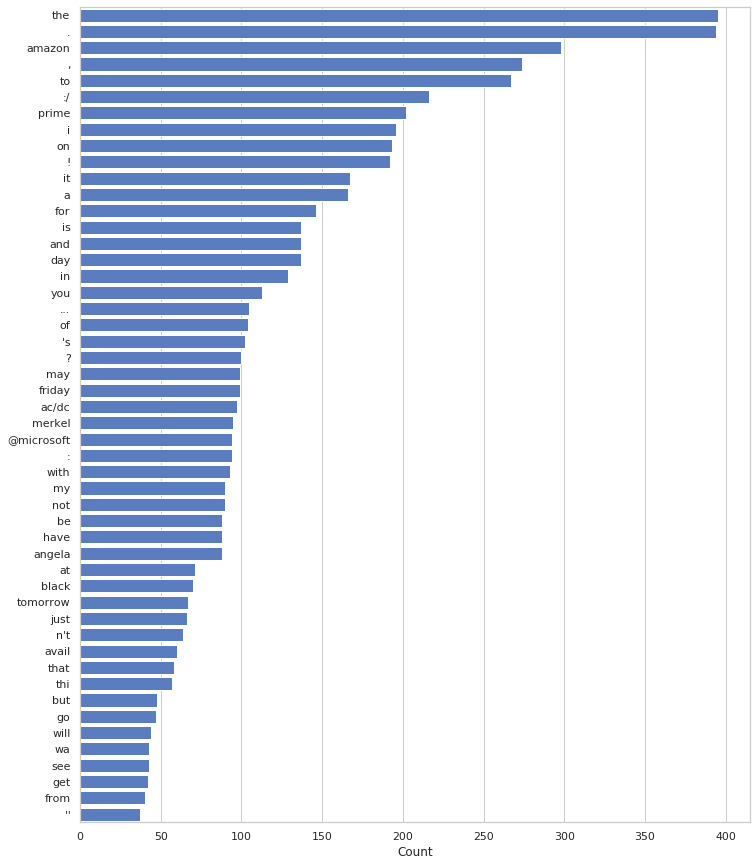

In [14]:
show_histogram(words.most_common(50))

# stopwords nie będą przydatne w dalszej analizie
# niektóre tokeny to znaki interpunkcyjne

Widać, że nie wszystkie tokeny to słowa. Ponieważ budujemy słownik słów, które będą wykorzystywane do klasyfikacji tekstów, usuńmy podstawowe tokeny, które nie niosą żadnej informacji.

**Zad. 6: Usuń znaki interpunkcyjne z kolekcji words i powtórz analizę. Czy w przypadku badania opinii trzeba wyrzucić wszystkie znaki interpunkcyjne?**

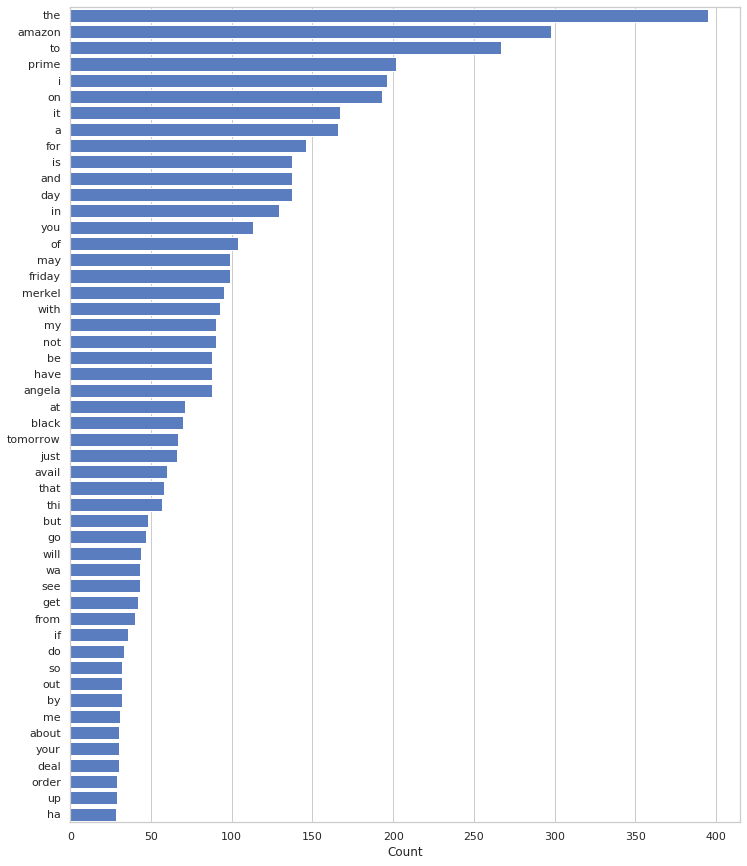

In [15]:
import string

for key in list(words.keys()):
    if set(key).intersection(string.punctuation) != set():
        del words[key]

show_histogram(words.most_common(50))

# znaki ! ? lub emotikony mogą być przydatne przy badaniu opinii

Wyraźnie widać, że nawet bez znaków intepunkcyjnych pozostało dużo zbędnych tokenów. Poniżej lista słów, które często są oznaczane jako tzw. stopwords, czyli słowa występujące często a nie niosące informacji.

In [16]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him",
            "himself", "his", "how", "i", "in", "into", "is", "it", "its", "itself", "let", "me", "more", "most", "my",
            "myself", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "sha",
            "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves",
            "then", "there", "there's", "these", "they", "this", "those", "through", "to", "until", "up", "very",
            "was", "we", "were", "what", "when", "where", "which", "while", "who","whom", "with", "would", "you",
            "your", "yours", "yourself", "yourselves",
            "n't", "'s", "'ll", "'re", "'d", "'m", "'ve",
            "above", "again", "against", "below", "but", "cannot", "down", "few", "if", "no", "nor", "not", "off",
            "out", "over", "same", "too", "under", "why"]

**Zad. 7: Korzystając z listy `sotpwords` usuń z kolekcji `words` popularne stopwords i ponów analizę. Czy wszystkie stopwords zawsze należy wyrzucać? Czy słowa takie jak "not" mogą być nośnikiem opinii? Jeśli masz jeszcze dużo czasu, możesz przeanalizować listę słów w nltk.corpus.stopwords.words('english')?**

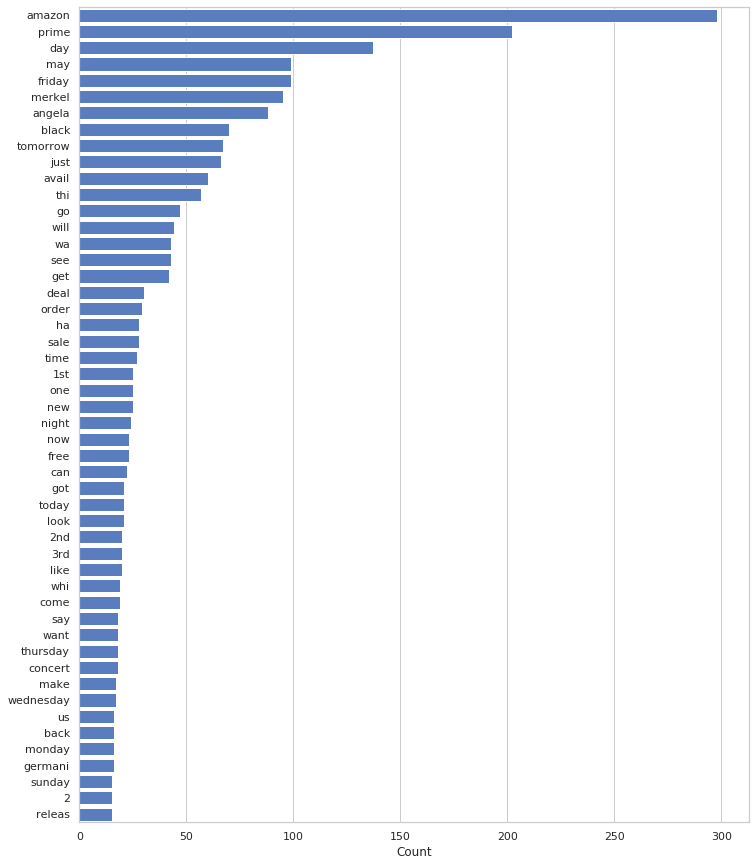

In [17]:
keys_to_remove = set(words.keys()).intersection(stopwords)

for key in keys_to_remove:
    del words[key]

show_histogram(words.most_common(50))

# słowa 'not' niosą informację o zaprzeczeniu informacji zawartej w opnii

Oprócz tokenów, które występują zbyt często, problemem bywają również najrzadsze tokeny.

**Zad. 8: Przeanalizuj 100 listę najrzadszych tokenów. Czy wszystkie tokeny są rzeczywiście rzadkie? Czy jakieś typy tokenów powtarzają się? Jak myślisz, co najlepiej zrobić z takimi tokenami jak 1, 2, 3... 10%, 20%, 30%..., 12:00, 19:50, 22:30, ..., 2005, 2010, 1995..., 10\$, 20\$, 30\$... ?**

In [18]:
print([x for x, y in words.most_common()[-100:]])

# nie wszystkie tokeny są rzadkimi słowami, 
# jedynie występują one rzadko w tym zbiorze danych

# tokeny liczbowe można by oznaczyć jednym wspólnym tokenem, np. <value>

['nation', 'confer', 'dog', 'european', 'carli', 'fiorina', 'smartest', 'snort', 'coke', '10yr', 'seek', 'imagin', 'african', 'multicultur', 'urg', 'protect', 'threw', 'weight', 'defin', 'french', 'solut', 'penis', 'cultur', 'belong', '9am', 'debat', 'illog', 'democraci', 'deutschen', 'nazi', 'accuss', 'betray', 'polic', 'clear', 'strong', 'washington', 'aug', '26', 'barack', 'voic', 'conduct', 'dnr', 'lnr', 'minsk', 'agreement', 'tat', 'azerbaijan', 'youngish', 'abe', 'fellow', 'stanc', 'canadian', 'zone', 'reform', 'digniti', 'stood', 'telegraph', 'passport', 'admitt', 'principl', 'movement', 'btw', 'biographi', 'predecessor', 'gerhard', 'schroeder', '22', 'prayer', 'hungari', 'budapest', 'catalonia', 'reappli', 'seced', 'spain', 'favour', 'sink', 'gunboat', 'colour', 'sweden', 'exampl', 'nobodi', 'ran', 'whole', 'must', 'graduat', 'humanitarian', 'citizen', 'concern', 'critic', 'action', 'xenophob', 'rare', 'shown', 'inclin', 'bold', 'restor', 'piti', 'organis', 'invas', 'columnista

Na tym etapie w zmiennej `words` mamy wstępnie przygotowany słownik. Jak widać słownik można by jeszcze ulepszyć, ale w tym ćwiczeniu poprzestaniemy na tym co do tej pory zrobiliśmy.

## Klasyfikacja

Mając słownik zamienimy przykłady uczące na reprezentację bag of words (BOW). W tej reprezentacji każdy przykład uczący (pojedynczy dokument tekstowy) przyjmuje formę wektora liczb. Każda pozycja w wektorze oznacza kolejne słowo ze słownika, a liczba na danej pozycji mówi czy (0-1) lub jak często (0-k) dane słowo występuje w tekście. Taka reprezentacja wektorowa ma tę zaletę, że można ją łatwo rozszerzać o dodatkowe atrybuty.

**Zad. 9: Przeanalizuj poniższy kod tworzący reprezentację bag-of-words. Co to jest `csr_matrix`? Czy wykorzystanie tej klasy jest konieczne?**

In [19]:
# csr_matrix to macierz rzadka umożliwiająca oszczędzanie pamięci,
# która w przypadku użycia zwykłej macierzy byłaby zużywana na 
# przechowywanie dużej ilości zer nieniosących żadnej informacji

def create_bow(documents, features):
    row = []
    col = []
    data = []

    labels = []

    for i in documents.index:
        tweet = BeforeTokenizationNormalizer.normalize(documents.iloc[i, 2])
        label = documents.iloc[i, 1]
        tweet_tokens = TweetTokenizer.tokenize(tweet)

        labels.append(label)
        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

Na koniec wykorzystajmy dotychczasową wiedzę, żeby nauczyć i przetestować klasyfikator.

**Zad. 10: Sprawdź działanie klasyfikatora Random Forest na przetworzonych wcześniej danych. Jak na trafność klasyfikacji wpływa parametr min_word_count?**

In [20]:
# min_word_count ma za zadanie wskazać minimalną liczbę słów,
# która jest używana do klasyfikacji. Gdy próg ten jest za niski,
# dane zawierają szum (niska jakość klasyfikacji). Gdy próg 
# jest za wysoki większość przypadków nie jest wybierana do 
# klasyfikacji -- zaczyna brakować danych (także niska jakość
# klasyfikacji). 

from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

for min_word_count in [1,2,3,4,5,15,25,45,65]:

    train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
    test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
    common_words = list([k for k, v in words.most_common() if v > min_word_count])

    feature_dict = {}
    for word in common_words:
        feature_dict[word] = len(feature_dict)

    print("Training classifier...")
    X_train, y_train = create_bow(train_tweets, feature_dict)
    list_of_labels = list(set(y_train))
    classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
    classifier.fit(X_train, y_train)

    print("Testing...")
    test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
    X_test, y_test = create_bow(test_tweets, feature_dict)
    predicted = classifier.predict(X_test)

    print("=================== Results ===================")
    print("min_word_count = ", min_word_count)
    print("            Positive    Neutral     Negative   ")
    print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
    print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
    print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
    print("")
    print("")

Training classifier...
Testing...
=================== Results ===================
min_word_count =  1
            Positive    Neutral     Negative   
F1        [0.72151899 0.24       0.        ]
Precision [0.59685864 0.3        0.        ]
Recall    [0.912 0.2   0.   ]


Training classifier...
Testing...
=================== Results ===================
min_word_count =  2
            Positive    Neutral     Negative   
F1        [0.72258065 0.2        0.02857143]
Precision [0.60540541 0.2        0.2       ]
Recall    [0.896      0.2        0.01538462]


Training classifier...
Testing...
=================== Results ===================
min_word_count =  3
            Positive    Neutral     Negative   
F1        [0.69257951 0.23255814 0.0952381 ]
Precision [0.62025316 0.17857143 0.21052632]
Recall    [0.784      0.33333333 0.06153846]


Training classifier...
Testing...
=================== Results ===================
min_word_count =  4
            Positive    Neutral     Negative   
F1  